In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os

sys.path.append("../")

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

os.environ["OMP_NUM_THREADS"] = "2"

In [3]:
def preprocessing():
    dataset = pd.read_csv("./data/german_credit_data.csv").drop("Unnamed: 0", axis=1)

    dataset.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

    for column in dataset.columns:
        if dataset[column].dtype != np.dtype("int64"):
            dataset[column] = LabelEncoder().fit_transform(dataset[column])

    return dataset


def train_model(x, y, model):
    cv = KFold(n_splits=3, random_state=None)
    global total_cm
    total_cm = np.zeros((2, 2))
    metric_dict = {}
    split_dict = {}

    it = 0
    for train_ind, test_ind in cv.split(x):
        x_train, x_test = x[train_ind], x[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        total_cm += confusion_matrix(y_test, y_pred)

        metrics = [
            accuracy_score(y_test, y_pred) * 100,
            precision_score(y_test, y_pred) * 100,
            recall_score(y_test, y_pred) * 100,
        ]

        metrics = np.round(metrics, decimals=2)

        metric_dict[it] = metrics
        split_dict[it] = (train_ind, test_ind)
        it += 1

    return total_cm, metric_dict, split_dict

In [4]:
global input_shape

dataset = preprocessing()

model = RandomForestClassifier(n_estimators=100, criterion="entropy")
# model2 = LogisticRegression(max_iter = 1000)

cols = dataset.iloc[:, :-1].columns.values
class_names = ["Bad Risk", "No Risk"]
X = dataset.drop(dataset.columns[-1], axis=1).values
Y = dataset.iloc[:, [-1]].values.reshape(-1,)

cm, metrics, splits = train_model(X, Y, model)

x_train, x_test = X[splits[0][0]], X[splits[0][1]]
y_train, y_test = Y[splits[0][0]], Y[splits[0][1]]

In [5]:
from chweimo.utils import split_by_cm

cm_splits, x_train, x_test, y_train, y_test = split_by_cm(X, Y, model)
cm_labels = ["true_neg", "false_neg", "true_pos", "false_pos"]

data_maximums = np.max(dataset.iloc[:, :-1])

discrete_map = np.where(
    data_maximums < 20, 1, 0
)  # Can use np.where(discrete_map == 1, cols, 0)
continuous_map = np.where(data_maximums > 20, 1, 0)
feature_map = {"continuous": continuous_map, "discrete": discrete_map}

c:\Users\kylei\Documents\GitHub\ChWeiMo\venv\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [11]:
from chweimo.counterfactual import Optimizer

explainer = Optimizer(X, Y, model.predict_proba)

x_orig = cm_splits[0][0]
x_orig_y = model.predict_proba(x_orig.reshape(1, -1)).reshape(-1)
change_class = np.argmin(x_orig_y)

explainer.generate_cf(
            sample=x_orig,
            change_class=change_class,
            termination=2,
            verbose=False
        )

explainer.show_cf(2, cols)

,Best of,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Distance,Pred Δ,Non-Dom?
0,Obj1,-19,0,-1,2,0,2,-531,-8,6,569.0,0.36,✓
1,Obj1,12,-1,0,1,2,0,843,-7,3,869.0,0.49,✓
2,Obj2,19,-1,-2,2,0,0,2161,-4,5,2194.0,0.53,✓
3,Obj2,15,-1,1,1,3,1,2683,-6,-1,2712.0,0.53,X


In [37]:
xs = pd.DataFrame(explainer.res_.history[-1].pop.get("X")-x_orig, columns=cols).head(5)
fs = (pd.DataFrame(explainer.res_.history[-1].pop.get("F"), columns=["Distance", "Pred Δ"])*-1).head(5)


non_dom_xs = pd.DataFrame(explainer.res_.X-x_orig, columns=cols)
non_dom_fs = pd.DataFrame(explainer.res_.F, columns=["Distance", "Pred Δ"])*-1
non_dom = pd.concat((non_dom_xs, non_dom_fs), axis=1)

n_solutions=2

fs["Distance"] = 1/fs["Distance"]
non_dom["Distance"] = 1/non_dom["Distance"]

combined = pd.concat((xs, fs), axis=1)

best_obj1 = combined.sort_values(by="Distance").head(n_solutions)
best_obj1.index = ["Obj1" for _ in range(best_obj1.shape[0])]

best_obj2 = combined.sort_values(by="Pred Δ", ascending=False).head(n_solutions)
best_obj2.index=["Obj2" for _ in range(best_obj2.shape[0])]


combined = pd.concat((best_obj1, best_obj2)).reset_index()
combined.rename({"index":"Best of"}, axis=1, inplace=True)

non_dom_col = np.full((combined.shape[0], 1), "X")

for i, v in combined.drop("Best of", axis=1).iterrows():
    for _, nv in non_dom.iterrows():
        if nv.equals(v):
            non_dom_col[i] = "✓"
            
combined["Non-Dom?"] = non_dom_col

def make_pretty(s):
    s.set_caption("Counterfactuals")
    
    s.apply(
        lambda s: np.where(s["Best of"] == "Obj1", ["background-color:#D55E00"]*len(s), ["background-color:#0072B2"]*len(s)), axis=1
        )
    
    s.apply(
        lambda s: np.where(s== "✓", "background-color:#009E73", "background-color:#CC79A7"), axis=0, subset=["Non-Dom?"]
        )
    
    s.set_table_styles([
        {"selector": "th.col_heading.level0", "props": "font-size:0.8em; background-color:black;"},
        {"selector": "th:not(.index_name)", "props": "font-size:0.8em; background-color:black;"},
        {"selector": "td, th", "props": [("border", "1px solid grey !important")]}
    ])
    
    
    
    s.format(
        precision=1, formatter={
            ("Distance"): "{:.1f}",
            ("Pred Δ"): "{:.2f}"}
        )
    
    return s

final = combined.style.pipe(make_pretty)
display(final)

# Need to make viable option (exclude counterfactuals including sex)

,Best of,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Distance,Pred Δ,Non-Dom?
0,Obj1,-19,0,-1,2,0,2,-531,-8,6,569.0,0.36,✓
1,Obj1,12,-1,0,1,2,0,843,-7,3,869.0,0.49,✓
2,Obj2,19,-1,-2,2,0,0,2161,-4,5,2194.0,0.53,✓
3,Obj2,15,-1,1,1,3,1,2683,-6,-1,2712.0,0.53,X


Index(['Obj1', 'Obj1', 'Obj2', 'Obj2'], dtype='object')

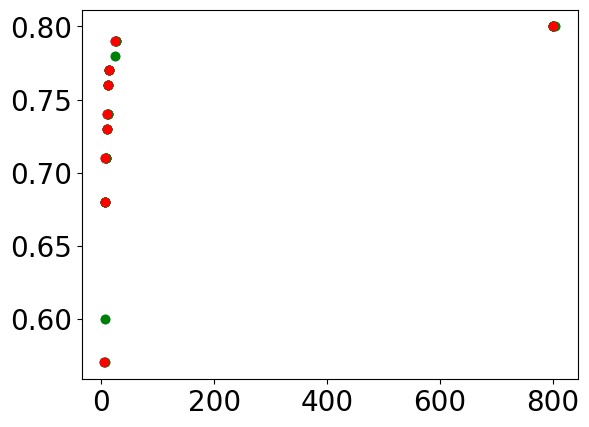

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(-1/explainer.res_.history[-1].pop.get("F")[:,0], explainer.res_.history[-1].pop.get("F")[:,1]*-1)
plt.scatter(-1/explainer.res_.history[-1].pop.get("F")[:,0], explainer.res_.history[-1].pop.get("F")[:,1]*-1, color="green")
plt.scatter(-1/explainer.res_.F[:,0], explainer.res_.F[:,1]*-1, color="red")